In [1]:
import os
import sys
sys.path.append(os.path.abspath('../..'))
from nowoe.data.api.smartwatch.utilities.preparations import *
import pandas
import plotly_express as px
import numpy
import json
import pickle
import gzip
import matplotlib.pyplot as plt
from copy import deepcopy
from functools import reduce
from tqdm import tqdm
from datetime import datetime, timezone
from typing import Dict, List, Tuple, Union, Any, Iterator
import torch.utils.data.dataloader
from nowoe.data.api.smartwatch.utilities.timestamp import get_utc_date_from_utc_timestamp
from nowoe.data.api.smartwatch.data_manager.module import SmartwatchDataManager
from nowoe.deep_learning.data.dataset.datasets.smartwatch_study.single_slice import SmartwatchStudySingleSliceDataset, single_slice_collate_fn

In [2]:
%%time
root = '../../resources/warrior_wellness/Analysis/local_repo/'
data_manager = SmartwatchDataManager(
    root_dir = root,
    subject_id_list=[f'SWS_{i:02d}' for i in range(0,15)]
)

CPU times: user 2min 30s, sys: 1.25 s, total: 2min 31s
Wall time: 2min 31s


In [3]:
args = {
    'data_manager': data_manager,
    'slice_lengths': [3600], #numpy.arange(1*3600, 2*3600, 15*60).tolist(),
    'slice_time_step': (5 * 60),
    'label_milestone_per_window': 1.0,
    'metadata_cache_filepath': './dataset_cache/dataset-cache-2.pkl.gz',
    'no_cache': False,
    'parallel_threads': 10
}

In [4]:
%%time
dataset = SmartwatchStudySingleSliceDataset(**args)
dataset_iter = iter(dataset)

2022-02-20 13:58:17,112 - nowoe.deep_learning.data.dataset.datasets.smartwatch_study.single_slice - INFO - Loaded metadata from cache file: /home/shayan/phoenix/nowoe_framework/nowoe_framework/notebooks/smartwatch/dataset_cache/dataset-cache-2.pkl.gz


CPU times: user 256 ms, sys: 16 ms, total: 272 ms
Wall time: 271 ms


In [6]:
{x.split('/')[1]: dataset.datapoint_counts[x] for x in dataset.datapoint_counts if x.split('/')[0] == 'overall'}

{'bin-0': 76210,
 'bin-1': 391,
 'bin-2': 266,
 'bin-3': 409,
 'bin-4': 87,
 'bin-5': 97,
 'bin-6': 110,
 'bin-7': 164,
 'bin-8': 18,
 'bin-9': 25,
 'bin-10': 14,
 'bin-11': 27,
 'bin-12': 4,
 'bin-13': 11,
 'bin-14': 7,
 'bin-15': 0,
 'bin-16': 0,
 'bin-17': 0,
 'bin-18': 0,
 'bin-19': 0,
 'bin-20': 0,
 'bin-21': 0,
 'bin-22': 0,
 'bin-23': 0,
 'bin-24': 0,
 'bin-25': 0,
 'bin-26': 0,
 'bin-27': 0,
 'bin-28': 0,
 'bin-29': 0,
 'bin-30': 0,
 'bin-31': 0,
 'bin-32': 0,
 'bin-33': 0,
 'bin-34': 0,
 'bin-35': 0}

Setting the above as a potential target, we will prepare a balanced sampler, as it is the best way to deal with this imbalance, while retaining enough negative examples.

The idea is to have repeated sampling so that we have N examples of each positive class, and N_neg examples of the neutral (negative) class.

In [11]:
numpy.random.choice(numpy.arange(500), 5, replace=True)

array([353, 350,  65,  78, 471])

In [13]:
len(dataset.metadata)

77840

The 15 labels are: 
	[0.0, 0.2571428571428571, 0.5142857142857142, 0.7714285714285714, 1.2857142857142856, 1.5428571428571427, 1.7999999999999998, 1.0285714285714285, 2.057142857142857, 2.314285714285714, 2.571428571428571, 2.8285714285714283, 3.0857142857142854, 3.3428571428571425, 3.5999999999999996]


In [28]:
numpy.nonzero(labels_per_index == 0)

(array([    0,     1,     2, ..., 77837, 77838, 77839]),)

In [68]:
class BalancedStressLevelSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, metadata, datapoint_counts):
        """
        We want to build the probability distribution of retaining an element from each one of the bins.
        
        Thus, we will follow the approach below:
        """
        self.metadata = metadata
        self.datapoint_counts = datapoint_counts
        
        overall_quantized_stress_value_layout = list(set([e['overall_quantized_stress_value'] for e in dataset.metadata]))
        labels_per_index = numpy.array([overall_quantized_stress_value_layout.index(e['overall_quantized_stress_value']) for e in dataset.metadata])
        
        indices = []
        N = 500
        for label_index in range(len(overall_quantized_stress_value_layout)):
            tmp_indices = numpy.random.choice(
                numpy.nonzero(labels_per_index == label_index)[0], 
                3 * N if label_index == 0 else N, 
                replace=True
            )
            tmp_labels = numpy.ones(tmp_indices.shape[0]) * label_index
            indices.append(tmp_indices)

        indices = numpy.concatenate(indices, axis=0)

        random_perm = numpy.random.permutation(indices.shape[0])
        indices = indices[random_perm]
        
        self.indices = indices

        
    def __iter__(self) -> Iterator[int]:
        for i in range(len(self.indices)):
            yield self.indices[i]
            
        
    def __len__(self) -> int:
        return len(self.indices)

In [69]:
dataloader = torch.utils.data.dataloader.DataLoader(dataset, sampler=BalancedStressLevelSampler(
    metadata = dataset.metadata, datapoint_counts = dataset.datapoint_counts), batch_size=50, collate_fn=single_slice_collate_fn)

In [70]:
dataloader_iter = iter(dataloader)

In [71]:
b = next(dataloader_iter)

In [72]:
sighted_labels = []
for batch in tqdm(dataloader):
    sighted_labels += [overall_quantized_stress_value_layout.index(e['overall_quantized_stress_value']) for e in batch['meta']]
sighted_labels = numpy.array(sighted_labels)

100%|█████████████████████████████████████████| 170/170 [01:19<00:00,  2.13it/s]


In [73]:
{x: (sighted_labels==x).sum() for x in range(len(overall_quantized_stress_value_layout))}

{0: 1500,
 1: 500,
 2: 500,
 3: 500,
 4: 500,
 5: 500,
 6: 500,
 7: 500,
 8: 500,
 9: 500,
 10: 500,
 11: 500,
 12: 500,
 13: 500,
 14: 500}

In [56]:
numpy.unique(sighted_labels)

array([0])

In [58]:
s = BalancedStressLevelSampler(metadata = dataset.metadata, datapoint_counts = dataset.datapoint_counts)

In [66]:
numpy.unique([dataset.metadata[i]['overall_quantized_stress_value'] for i in s])

array([0.])

In [117]:
sample_meta

{'subject_id': 'SWS_03',
 'utc_timestamp_window': (1615478700.0, 1615482300.0),
 'overall_stress_value': 2.9850854667840334,
 'general_stress_value': 0.0,
 'interpersonal_stress_value': 1.0126712332962011,
 'utc_timestamp_for_stress_query': 1615482300.0,
 'induced_stress_value': 1.9724142334878325,
 'general_quantized_stress_value': 0.0,
 'induced_quantized_stress_value': 1.909090909090909,
 'interpersonal_quantized_stress_value': 0.8181818181818181,
 'overall_quantized_stress_value': 2.8285714285714283}

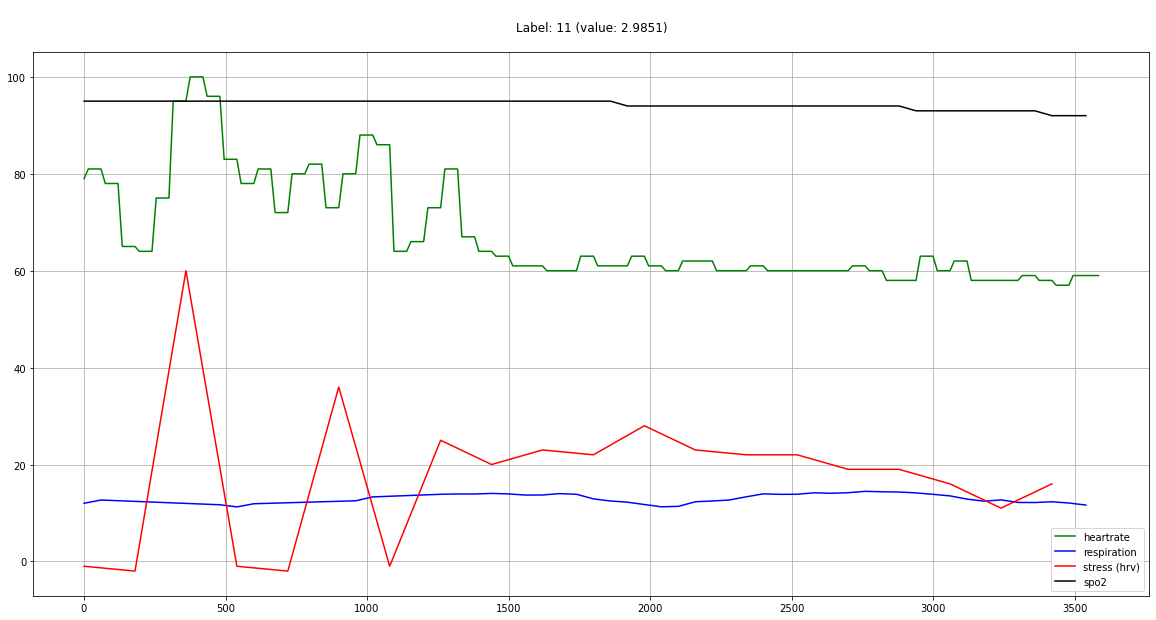

In [116]:
sample_slice_index = numpy.random.choice(len(batch['slice']))
sample_slice = batch['slice'][sample_slice_index]
sample_meta = batch['meta'][sample_slice_index]

plt.figure(figsize=(20, 10))

plt.title(f"""
Label: {overall_quantized_stress_value_layout.index(sample_meta['overall_quantized_stress_value'])} (value: {sample_meta['overall_stress_value']:.4f})
""")

plt.grid()
legends = []

try:
    plt.plot(sample_slice['daily'].utc_timestamp.to_numpy() - sample_slice['daily'].utc_timestamp.to_numpy()[0], sample_slice['daily'].heart_rate_tsvalue, 'g-')
    legends += ['heartrate']
except:
    pass

try:
    plt.plot(sample_slice['respiration'].utc_timestamp.to_numpy() - sample_slice['respiration'].utc_timestamp.to_numpy()[0], sample_slice['respiration'].epoch_to_breath_tsvalue, 'b-')
    legends += ['respiration']
except:
    pass

try:
    plt.plot(sample_slice['stress'].utc_timestamp.to_numpy() - sample_slice['stress'].utc_timestamp.to_numpy()[0], sample_slice['stress'].stress_level_tsvalue, 'r-')
    legends += ['stress (hrv)']
except:
    pass

try:
    plt.plot(sample_slice['pulseOx'].utc_timestamp.to_numpy() - sample_slice['pulseOx'].utc_timestamp.to_numpy()[0], sample_slice['pulseOx'].spo2_tsvalue, 'k-', )
    legends += ['spo2']
except:
    pass

plt.legend(legends)

In [86]:
sample_slice.keys()

dict_keys(['daily', 'respiration', 'stress', 'pulseOx'])

In [93]:
sample_slice['pulseOx']

,utc_timestamp,spo2_tsvalue,summaryId,durationInSeconds,startTimeInSeconds,calendarDate,onDemand,user_id,startTimeOffsetInSeconds,utc_date
2763,1615479420,95,x38beb34-6049a3d0,86400,1615438800,2021-03-11,False,SWS_03,-18000,2021-03-11 16:17:00+00:00
2764,1615479720,95,x38beb34-6049a3d0,86400,1615438800,2021-03-11,False,SWS_03,-18000,2021-03-11 16:22:00+00:00
2765,1615479780,95,x38beb34-6049a3d0,86400,1615438800,2021-03-11,False,SWS_03,-18000,2021-03-11 16:23:00+00:00
2766,1615480020,95,x38beb34-6049a3d0,86400,1615438800,2021-03-11,False,SWS_03,-18000,2021-03-11 16:27:00+00:00
2767,1615480080,95,x38beb34-6049a3d0,86400,1615438800,2021-03-11,False,SWS_03,-18000,2021-03-11 16:28:00+00:00
2768,1615480140,95,x38beb34-6049a3d0,86400,1615438800,2021-03-11,False,SWS_03,-18000,2021-03-11 16:29:00+00:00
2769,1615480200,95,x38beb34-6049a3d0,86400,1615438800,2021-03-11,False,SWS_03,-18000,2021-03-11 16:30:00+00:00
2770,1615480260,95,x38beb34-6049a3d0,86400,1615438800,2021-03-11,False,SWS_03,-18000,2021-03-11 16:31:00+00:00
2771,1615480320,95,x38beb34-6049a3d0,86400,1615438800,2021-03-11,False,SWS_03,-18000,2021-03-11 16:32:00+00:00
2772,1615480440,95,x38beb34-6049a3d0,86400,1615438800,2021-03-11,False,SWS_03,-18000,2021-03-11 16:34:00+00:00
